<a href="https://colab.research.google.com/github/DrashiDave/DATA-603/blob/main/Assignment%20-%204/Streaming_ISS_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **STREAMING DATA**


## **Install Required Libraries and Kafka**

 This notebook demonstrates how to use Kafka and Spark to fetch and visualize satellite tracking data from the International Space Station (ISS) using the api.open-notify.org.


I have installed kafka-python, requests, and cartopy for data streaming, fetching the ISS data, and visualizing the satellite location, respectively. Additionally, we will download, extract, and set up Kafka.

In [ ]:
!pip install kafka-python requests cartopy

Downloading and extracting kafka

In [ ]:
!curl -sSOL https://dlcdn.apache.org/kafka/3.9.0/kafka_2.13-3.9.0.tgz
!tar -xzf kafka_2.13-3.9.0.tgz

Start Zookeeper and Kafka servers in the background

In [ ]:
!./kafka_2.13-3.9.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.9.0/config/zookeeper.properties
!./kafka_2.13-3.9.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.9.0/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


Waiting for Kafka services to initialize

In [ ]:
!ps -ef | grep kafka

root       10796    8975  0 19:15 ?        00:00:00 /bin/bash -c ps -ef | grep kafka
root       10798   10796  0 19:15 ?        00:00:00 grep kafka


Creating a new Kafka topic for ISS location data and deleting any existing topic with the same name that prints error if the same name is not found

In [ ]:
!./kafka_2.13-3.9.0/bin/kafka-topics.sh --delete --bootstrap-server 127.0.0.1:9092 --topic iss_location

In [ ]:
!./kafka_2.13-3.9.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic iss_location


Created topic iss_location.


## **Kafka and API setup**

This cell sets up all the required libraries and initial configuration parameters, such as the Kafka server address, API endpoint, and streaming parameters.

In [ ]:
import json
import requests
from kafka import KafkaProducer
import time
from kafka import KafkaConsumer
import json
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import threading
from datetime import datetime, timedelta
import pandas as pd
from requests.exceptions import RequestException

# Configuration for Kafka server and topic
TOPIC_NAME = 'iss_tracking'
SERVER_ADDRESS = '127.0.0.1:9092'

# API URL and retry settings for ISS location data
ISS_API_URL = "http://api.open-notify.org/iss-now.json"
RETRY_LIMIT = 3
DELAY_BETWEEN_RETRIES = 1  # in seconds

# Streaming settings
POLLING_INTERVAL = 5
STREAM_DURATION = timedelta(minutes=60)

print("Setup complete.")

Setup complete.


### **Fetching ISS Data**

This cell defines fetch_iss_data(), a function that retrieves the current location of the ISS from the Open Notify API.
It includes error handling and retry mechanisms to ensure reliable data fetching even in case of network issues.


In [ ]:
def retrieve_iss_location(retry_count=RETRY_LIMIT, delay=DELAY_BETWEEN_RETRIES):

    for attempt in range(retry_count):
        try:
            response = requests.get(ISS_API_URL, timeout=10)
            response.raise_for_status()
            return response.json()
        except RequestException as error:
            print(f"Attempt {attempt + 1} failed: {str(error)}")
            if attempt < retry_count - 1:
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                print("Failed to retrieve data after maximum retries.")
                return None

print("ISS data retrieval function defined.")


ISS data retrieval function defined.


## **Kafka Producer: Streaming ISS Data**

The function starts a Kafka producer to publish ISS location data. Sends data at regular intervals to the defined Kafka topic for a specified duration.


In [ ]:
def start_producer():

    producer = KafkaProducer(
        bootstrap_servers=[SERVER_ADDRESS],
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )

    end_time = datetime.now() + STREAM_DURATION

    while datetime.now() < end_time:
        location_data = retrieve_iss_location()
        if location_data:
            producer.send(TOPIC_NAME, value=location_data)
            print(f"Published data: {location_data}")
        else:
            print("No data to send, skipping...")

        time.sleep(POLLING_INTERVAL)

    producer.close()
    print("Producer session closed.")

### **Plotting ISS Location Path**

Here, we define plot_iss_path(), which generates a global map with the ISS's path plotted as a series of red markers.
The function uses Cartopy to create the map visualization and Matplotlib to display the trajectory based on streamed latitude and longitude data.

In [ ]:
# Function to plot the ISS path on a world map
def display_iss_path(data_frame):

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.set_global()

    # Plot the ISS path as red dots on the map
    ax.plot(data_frame['longitude'], data_frame['latitude'], 'ro-', transform=ccrs.Geodetic(), markersize=5)
    plt.title("Real-time ISS Position Tracking")
    plt.show()

print("ISS path plotting function ready.")



ISS path plotting function ready.


### **Kafka Consumer: Retrieve and Visualize ISS Path**

The kafka_consumer() function consumes ISS data from Kafka topic and visualizes it on a map. Retrieves location data, stores in a DataFrame, and displays the ISS path on a global map. The consumer gathers data, constructs the path, and displays it on the map.

Published data: {'message': 'success', 'iss_position': {'latitude': '32.2609', 'longitude': '16.9703'}, 'timestamp': 1731007071}
Attempt 1 failed: HTTPConnectionPool(host='api.open-notify.org', port=80): Max retries exceeded with url: /iss-now.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7d52fbf7bd60>, 'Connection to api.open-notify.org timed out. (connect timeout=10)'))
Retrying in 1 seconds...
Published data: {'message': 'success', 'iss_position': {'latitude': '33.0057', 'longitude': '17.8635'}, 'timestamp': 1731007088}
Attempt 1 failed: HTTPConnectionPool(host='api.open-notify.org', port=80): Max retries exceeded with url: /iss-now.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7d52fbfd0e20>, 'Connection to api.open-notify.org timed out. (connect timeout=10)'))
Retrying in 1 seconds...
Published data: {'message': 'success', 'iss_position': {'latitude': '34.0228', 'longitude': '19.1250'}, 'timestamp': 173100711

Producer session closed.


<ipython-input-11-fd3ec4a84fdb>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  iss_positions = pd.concat([iss_positions, pd.DataFrame({'latitude': [latitude], 'longitude': [longitude]})], ignore_index=True)


Received data: {'message': 'success', 'iss_position': {'latitude': '-51.4079', 'longitude': '-87.5285'}, 'timestamp': 1731005081}
Received data: {'message': 'success', 'iss_position': {'latitude': '-51.3655', 'longitude': '-86.8867'}, 'timestamp': 1731005087}
Received data: {'message': 'success', 'iss_position': {'latitude': '-51.3230', 'longitude': '-86.2954'}, 'timestamp': 1731005093}
Received data: {'message': 'success', 'iss_position': {'latitude': '-51.2772', 'longitude': '-85.7052'}, 'timestamp': 1731005099}
Received data: {'message': 'success', 'iss_position': {'latitude': '-51.1347', 'longitude': '-84.0879'}, 'timestamp': 1731005116}
Received data: {'message': 'success', 'iss_position': {'latitude': '-51.0868', 'longitude': '-83.6003'}, 'timestamp': 1731005121}
Received data: {'message': 'success', 'iss_position': {'latitude': '-50.9187', 'longitude': '-82.0476'}, 'timestamp': 1731005137}
Received data: {'message': 'success', 'iss_position': {'latitude': '-50.7780', 'longitude'

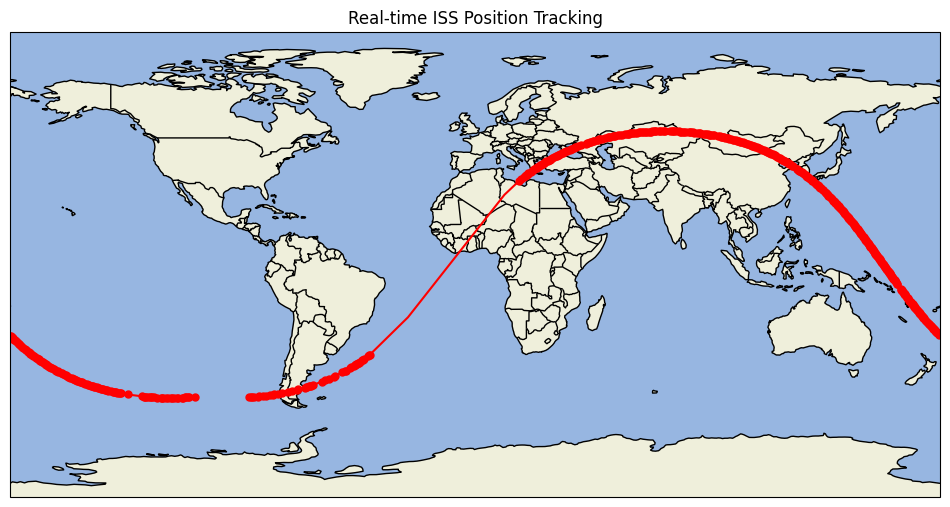

In [ ]:
def start_consumer():

    consumer = KafkaConsumer(
        TOPIC_NAME,
        bootstrap_servers=[SERVER_ADDRESS],
        value_deserializer=lambda x: json.loads(x.decode('utf-8')),
        auto_offset_reset='earliest',  # Start from the earliest message
        consumer_timeout_ms=1000,
    )

    iss_positions = pd.DataFrame(columns=['latitude', 'longitude'])

    for message in consumer:
        data = message.value
        print(f"Received data: {data}")

        # Extract latitude and longitude from the Kafka message
        latitude = float(data['iss_position']['latitude'])
        longitude = float(data['iss_position']['longitude'])

        # Append to DataFrame
        iss_positions = pd.concat([iss_positions, pd.DataFrame({'latitude': [latitude], 'longitude': [longitude]})], ignore_index=True)

    # Plotting the path after collecting all data
    display_iss_path(iss_positions)
    print("Consumer session closed.")

# Run producer
start_producer()
# Run consumer
start_consumer()

The above graph shows the real-time path of the International Space Station (ISS) as it orbits around Earth. Each dot marks the ISS's location at regular intervals. The red line of points highlights the ISS's rapid movement across different coordinates.